# Gradient Boosting from scratch

## Reference
https://medium.com/mlreview/gradient-boosting-from-scratch-1e317ae4587d
https://nbviewer.jupyter.org/github/groverpr/Machine-Learning/blob/master/notebooks/01_Gradient_Boosting_Scratch.ipynb

### Ensemble, Bagging and Boosting
* **Ensemble** is just a collection of predictors which come together to give a final prediction.
* **Bagging** is a simple ensembling technique in which we build many independent predictors/models/learners and combine them using some model averaging techniques.
* **Boosting** is an ensemble technique in which the predictors are not made independently, but sequentially. The observations have an unequal probability of appearing in subsequent models and ones with highest error appear most.

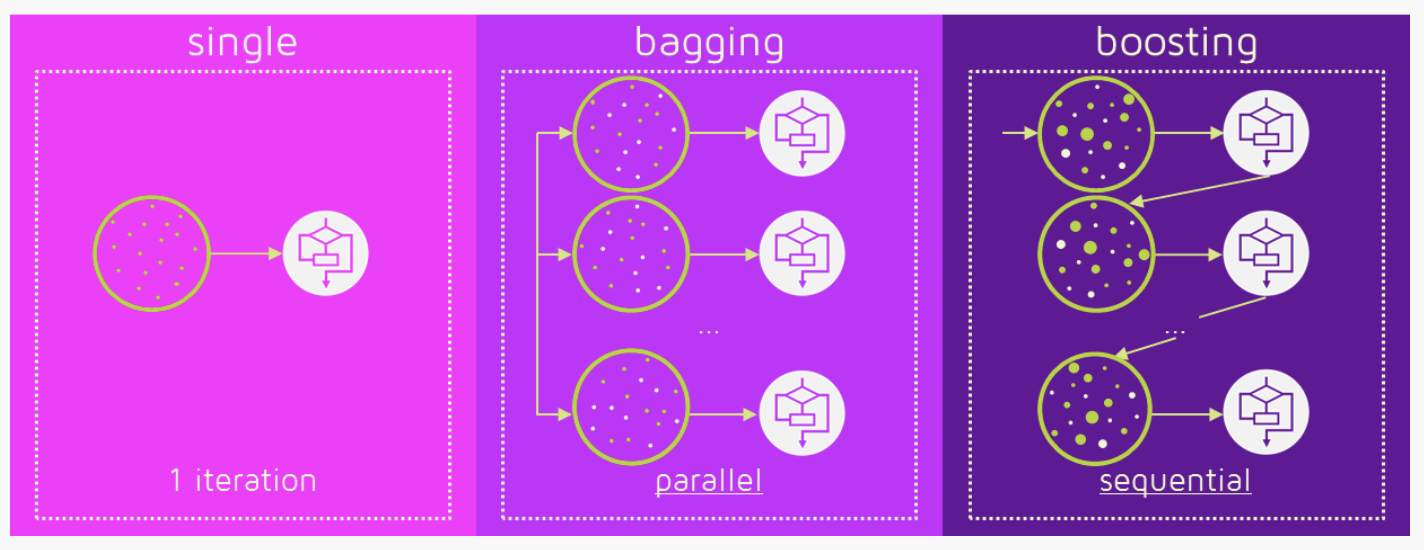
Ref: https://quantdare.com/what-is-the-difference-between-bagging-and-boosting/



In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from IPython.display import display
from sklearn import metrics
import math

In [ ]:
def std_agg(cnt, s1, s2): 
    return math.sqrt((s2/cnt) - (s1/cnt)**2)

In [31]:
class DecisionTree():
    def __init__(self, x, y, idxs = None, min_leaf=2):
        if idxs is None: 
            idxs = np.arange(len(y))
        self.x, self.y, self.idxs, self.min_leaf = x, y, idxs, min_leaf
        self.n, self.c = len(idxs), x.shape[1]
        self.val = np.mean(y[idxs])
        self.score = float('inf')
        self.find_varsplit()
        
    def find_varsplit(self):
        for i in range(self.c): 
            self.find_better_split(i)
        if self.score == float('inf'): 
            return
        x = self.split_col
        lhs = np.nonzero(x<=self.split)[0]
        rhs = np.nonzero(x>self.split)[0]
        self.lhs = DecisionTree(self.x, self.y, self.idxs[lhs])
        self.rhs = DecisionTree(self.x, self.y, self.idxs[rhs])

    def find_better_split(self, var_idx):
        x,y = self.x.values[self.idxs,var_idx], self.y[self.idxs]
        sort_idx = np.argsort(x)
        sort_y,sort_x = y[sort_idx], x[sort_idx]
        rhs_cnt,rhs_sum,rhs_sum2 = self.n, sort_y.sum(), (sort_y**2).sum()
        lhs_cnt,lhs_sum,lhs_sum2 = 0,0.,0.
        
        for i in range(0,self.n-self.min_leaf-1):
            xi,yi = sort_x[i],sort_y[i]
            lhs_cnt += 1; rhs_cnt -= 1
            lhs_sum += yi; rhs_sum -= yi
            lhs_sum2 += yi**2; rhs_sum2 -= yi**2
            if i<self.min_leaf or xi==sort_x[i+1]:
                continue

            lhs_std = std_agg(lhs_cnt, lhs_sum, lhs_sum2)
            rhs_std = std_agg(rhs_cnt, rhs_sum, rhs_sum2)
            curr_score = lhs_std*lhs_cnt + rhs_std*rhs_cnt
            if curr_score<self.score: 
                self.var_idx,self.score,self.split = var_idx,curr_score,xi
    
    @property
    def split_name(self): 
        return self.x.columns[self.var_idx]
    
    @property
    def split_col(self): 
        return self.x.values[self.idxs,self.var_idx]

    @property
    def is_leaf(self): 
        return self.score == float('inf')
    
    def __repr__(self):
        s = f #'n: {self.n}; val:{self.val}'
        if not self.is_leaf:
            s += f #'; score:{self.score}; split:{self.split}; var:{self.split_name}'
        return s

    def predict(self, x):
        return np.array([self.predict_row(xi) for xi in x])

    def predict_row(self, xi):
        if self.is_leaf: return self.val
        t = self.lhs if xi[self.var_idx]<=self.split else self.rhs
        return t.predict_row(xi)

### Gradient Boosting in 2D data

In [26]:
x = np.arange(0,50)
x = pd.DataFrame({'x':x})
y1 = np.random.uniform(10,15,10)
y2 = np.random.uniform(20,25,10)
y3 = np.random.uniform(0,5,10)
y4 = np.random.uniform(30,32,10)
y5 = np.random.uniform(13,17,10)

y = np.concatenate((y1,y2,y3,y4,y5))
y = y[:,None]

In [27]:
x.shape, y.shape

((50, 1), (50, 1))

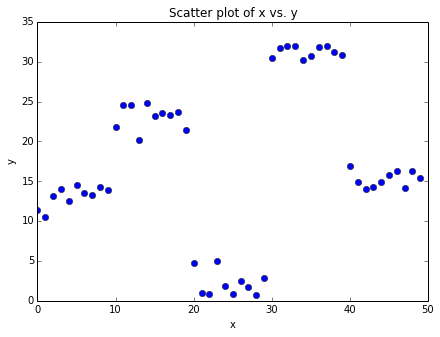

In [28]:
plt.figure(figsize=(7,5))
plt.plot(x,y, 'o')
plt.title("Scatter plot of x vs. y")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

## Steps to fit a Gradient Boosting model
1. Fit a simple linear regressor or decision tree on data (x,y).
2. Calculate error residuals (e1 = y - ypred1)
3. Fit a new model on error residuals as target variable with same input variables (e1_pred)
4. Add the predicted residuals to the previous predictions (ypred2 = ypred1 + e1_pred)
5. Fit another model on residuals that is still left. (e2 = y - ypred2)

Repeat steps2 to 5 until it starts overfitting or the sum of residuals become constant.

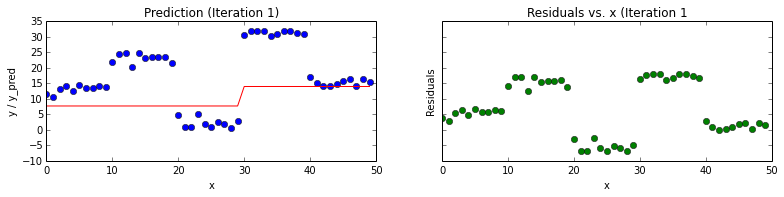

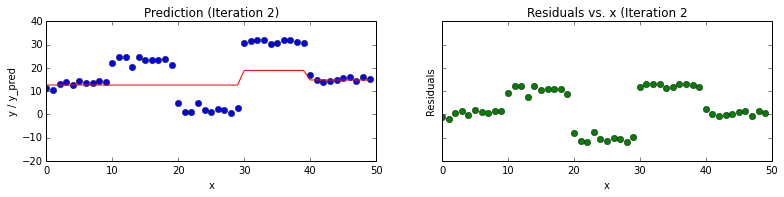

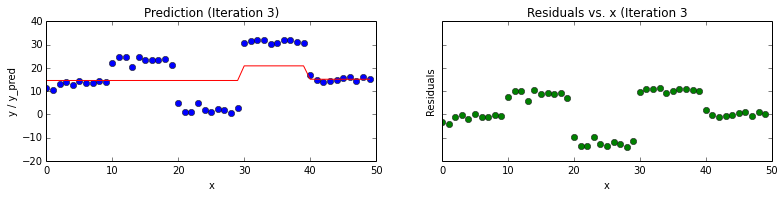

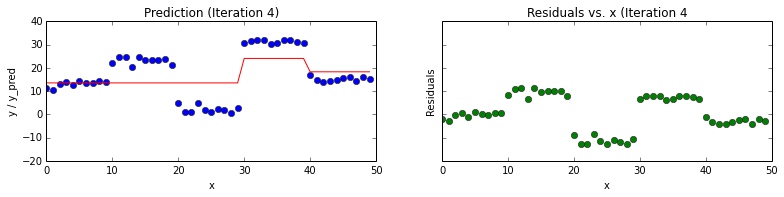

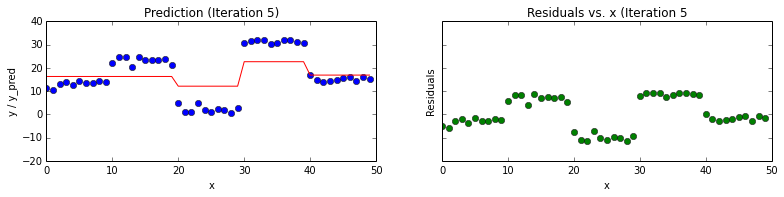

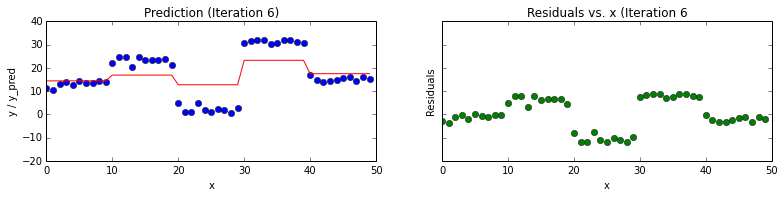

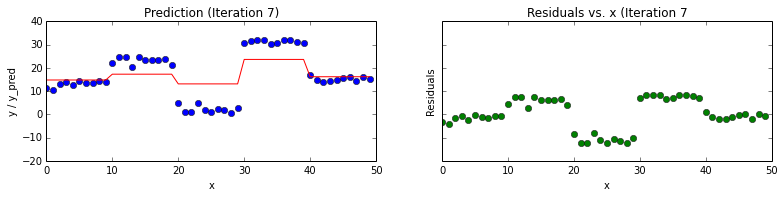

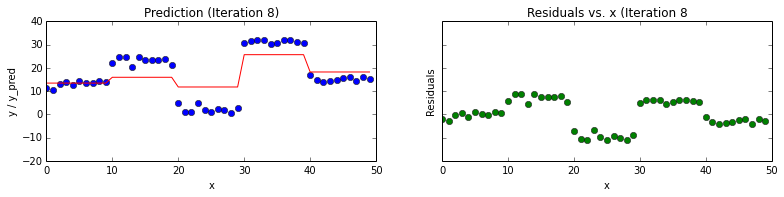

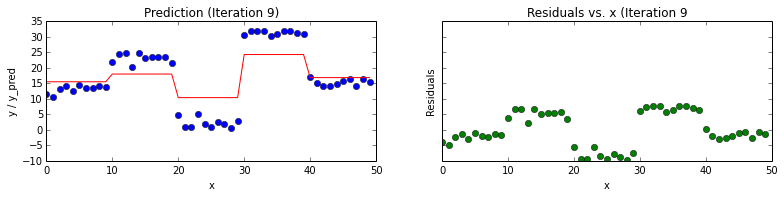

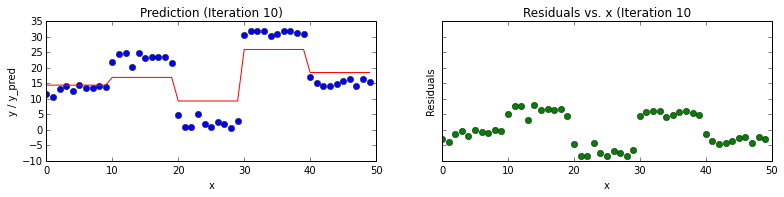

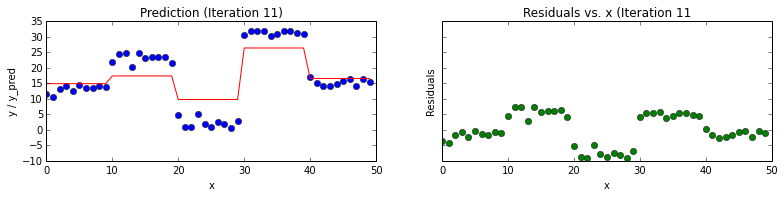

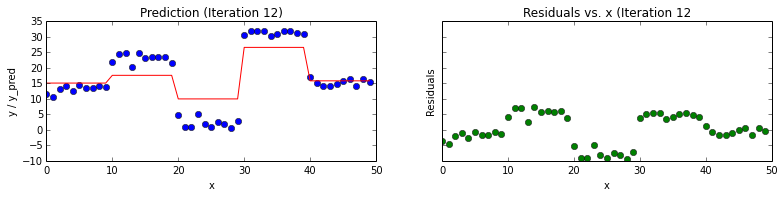

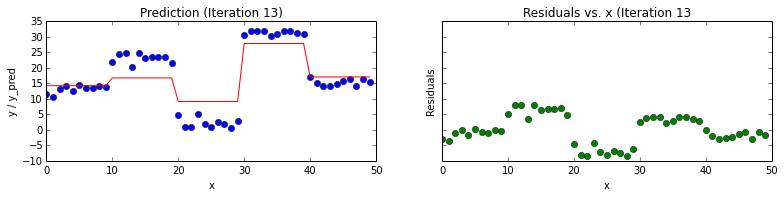

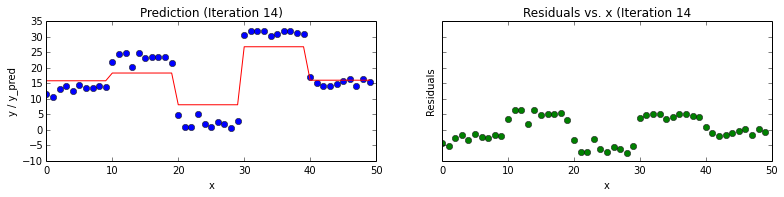

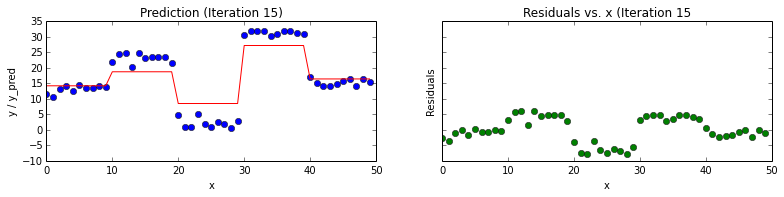

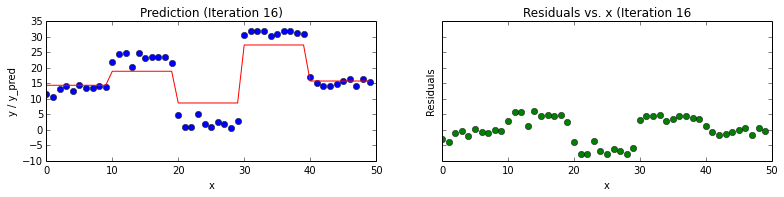

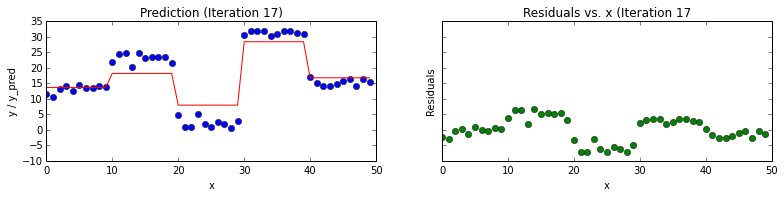

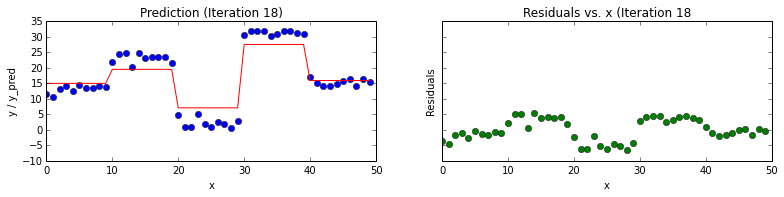

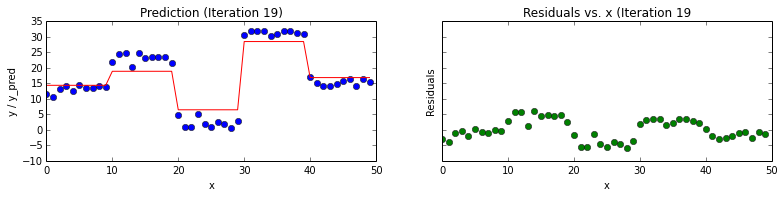

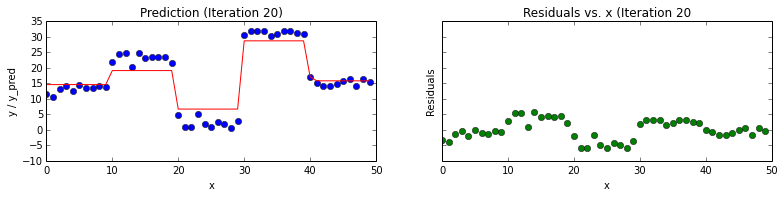

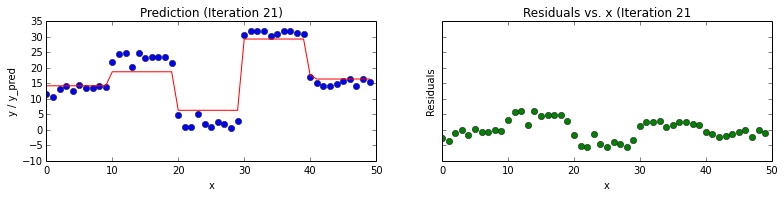

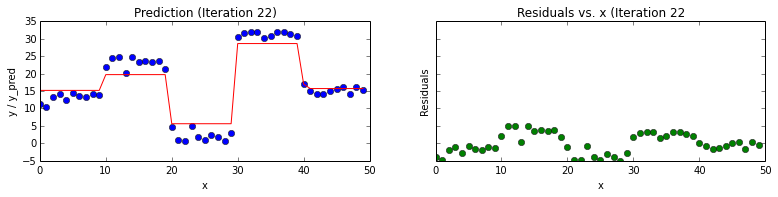

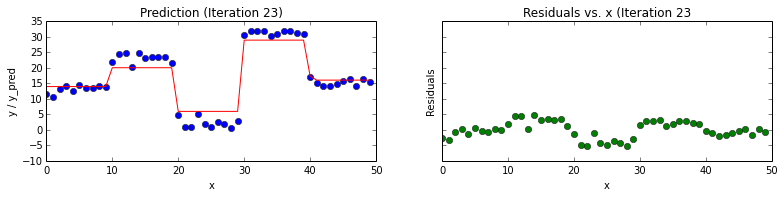

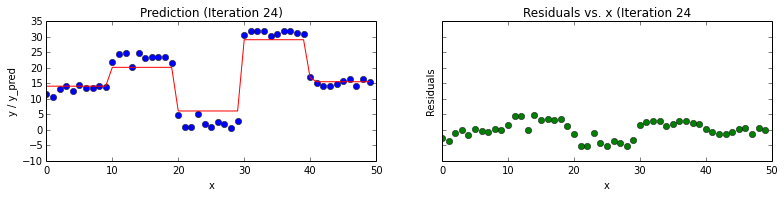

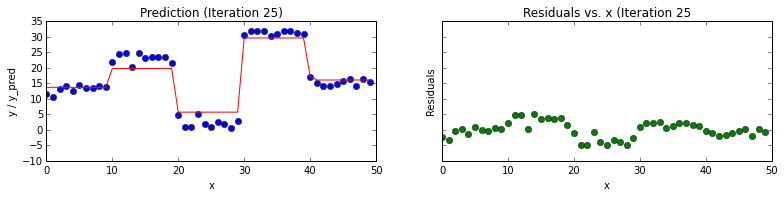

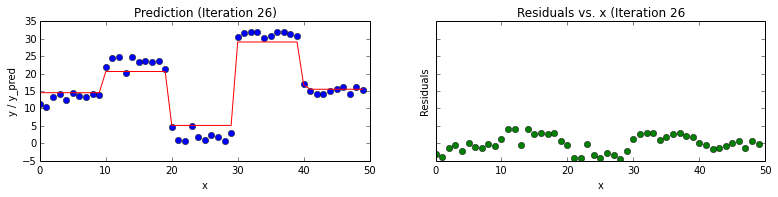

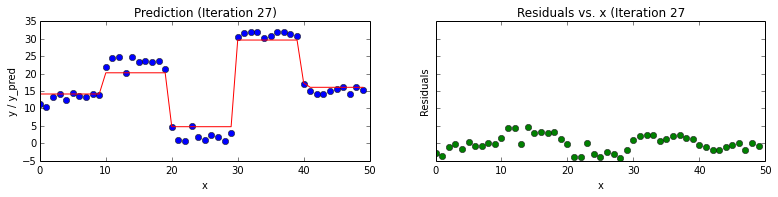

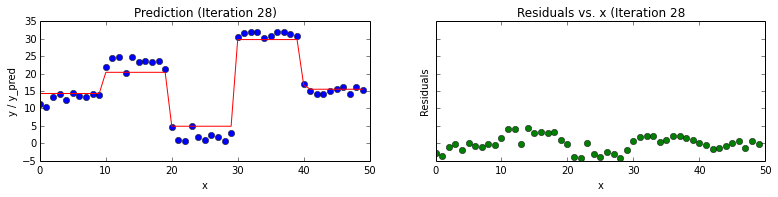

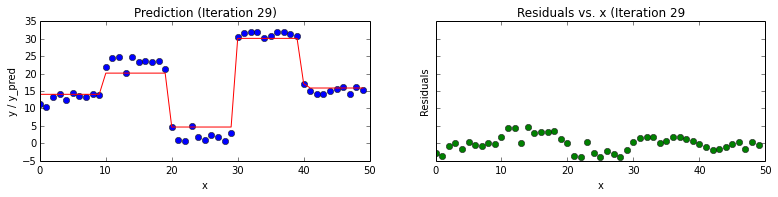

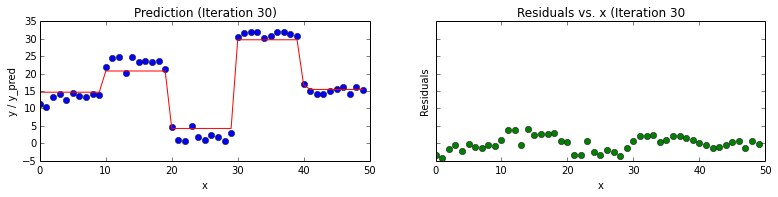

In [42]:
xi = x # initialization of input
yi = y # initialization of target
# x,y --> use where no need to change original y
ei = 0 # initialization of error
n = len(yi)  # number of rows
predf = 0 # initial prediction 0

num_rounds = 30
learning_rate = 0.3
for i in range(num_rounds): # like n_estimators
    tree = DecisionTree(xi,yi)
    tree.find_better_split(0)
    
    r = np.where(xi == tree.split)[0][0]    
    
    left_idx = np.where(xi <= tree.split)[0]
    right_idx = np.where(xi > tree.split)[0]
    
    predi = np.zeros(n)
    np.put(predi, left_idx, np.repeat(np.mean(yi[left_idx]), r))  # replace left side mean y
    np.put(predi, right_idx, np.repeat(np.mean(yi[right_idx]), n-r))  # right side mean y
    
    predi = predi[:,None]  # make long vector (nx1) in compatible with y
    predf = predf + 2*learning_rate*predi  # final prediction will be previous prediction value + new prediction of residual
    
    ei = y - predf  # needed originl y here as residual always from original y    
    yi = ei # update yi as residual to reloop
    
    xa = np.array(x.x) # column name of x is x 
    order = np.argsort(xa)
    xs = np.array(xa)[order]
    ys = np.array(predf)[order]
    
    #epreds = np.array(epred[:,None])[order]

    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize = (13,2.5))

    ax1.plot(x,y, 'o')
    ax1.plot(xs, ys, 'r')
    ax1.set_title("Prediction (Iteration "+str(i+1)+")")
    ax1.set_xlabel('x')
    ax1.set_ylabel('y / y_pred')

    ax2.plot(x, ei, 'go')
    ax2.set_title("Residuals vs. x (Iteration "+str(i+1)+"")
    ax2.set_xlabel('x')
    ax2.set_ylabel('Residuals')